<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/simple_cats_dogs_classificationSoumyojit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 09th Sep, 2023
# My folder: E:/cats_and_dogs/data
# Google drive: /content/drive/MyDrive/Colab_data_files
# Data folder:  '/home/ashok/Images/cats_dogs/
# VM: lubuntu_deeplearning_I
#
# Objectives:
#           i)  Building powerful image classification models using
#               very little data
#           ii) Using image data-augmentation techniques
#           iii)Predicting cats and dogs--Kaggle
#               https://www.kaggle.com/c/dogs-vs-cats
#           iv) Calcualting model weights, stage-by-stage
#            v) Saving model-weights and model-architecture to files
#           vi) Loading saved model-architecture and model-weights

In [ ]:
'''

A. Arrange your data first
==========================

    Download data from: https://www.kaggle.com/c/dogs-vs-cats/data .
    Unzip train.zip and arrange its files as follows:
        data/
            train/
                dogs/                      1000
                    dog001.jpg
                    dog002.jpg
                    ...
                    dog1000.jpg
                cats/                      1000
                    cat001.jpg
                    cat002.jpg
                    ...
                    cat1000.jpg
           validation/
               dogs/                        400
                   dog1001.jpg
                   dog1002.jpg
                   ...
                   dog1400.jpg
              cats/                         400
                  cat1001.jpg
                  cat1002.jpg
                  ...
                  cat1004.jpg

    So we are picking up only 1000 files of each category for training.
    Arrangement of (only) 'training' files in this fashion has an advantage that
    keras automatically knows which images are of cats and which images are
    of dogs. It does automatic labeling of images; we do not have to specify
    explicitly in the code for building training model. This automatic labelling
    is done by ImageGenerator.


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
# Mount drive at /gdrive:

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
#%%                                A. Call libraries

#        $ source activate theano
#        $ ipython
# OR in Windows
#       > conda activate tensorflow_env
#       > atom


# 1.0 Data manipulation library
#     Install in 'tf' environment
#     conda install -c anaconda pandas
import pandas as pd

# 1.1 Call libraries for image processing
#     Another preprocessing option is text and sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1.2, Libraries for building sequential CNN model
#      A model is composed of sequence of layered objects
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input

# 1.5 OS related
import os

# 1.6 For ROC plotting
import matplotlib.pyplot as plt

# 1.7
import numpy as np
# conda install scikit-learn
from sklearn import metrics
import time


In [ ]:
!ls

sample_data


In [ ]:
!pwd

/content


In [4]:
! ls  /content/sample_data

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [5]:
!mkdir /content/sample_data/xyz

In [ ]:
! mkdir /content/sample_data/abc

In [ ]:
! rm -r -f /content/sample_data/abc/

In [ ]:
! ls /root

In [6]:
# 1.9 Make two folders, one for .tar.gz file
#     and the other for unzipped files
! mkdir /root/catsdogs
! mkdir /root/ashok

In [ ]:
!ls /root

ashok  catsdogs


In [7]:
# 1.10 Copy tar.gz file from Google drive to Virtual machine
! cp /gdrive/MyDrive/deeplearning/cats_dogs.tar.gz  /root/catsdogs

# 1.11 And check
! ls /root/catsdogs

cp: cannot stat '/gdrive/MyDrive/deeplearning/cats_dogs.tar.gz': No such file or directory


In [8]:
# 1.10 Copy tar.gz file from Google drive to Virtual machine
! cp /gdrive/MyDrive/Colab_data_files/cats_dogs/*.*  /root/catsdogs

# 1.11 And check
! ls /root/catsdogs

cats_dogs.tar.gz


In [9]:
# 1.12 Untar file to folder /root/ashok/ :

! tar -xvf /root/catsdogs/cats_dogs.tar.gz  -C /root/ashok

cats_dogs/train/cats/cat.637.jpg
cats_dogs/train/cats/cat.540.jpg
cats_dogs/validation/cats/cat.1374.jpg
cats_dogs/train/dogs/dog.95.jpg
cats_dogs/validation/dogs/dog.1297.jpg
cats_dogs/train/cats/cat.698.jpg
cats_dogs/train/cats/cat.828.jpg
cats_dogs/train/cats/cat.54.jpg
cats_dogs/train/cats/cat.249.jpg
cats_dogs/validation/cats/cat.1116.jpg
cats_dogs/train/dogs/dog.257.jpg
cats_dogs/validation/dogs/dog.1039.jpg
cats_dogs/train/cats/cat.152.jpg
cats_dogs/train/dogs/dog.984.jpg
cats_dogs/train/cats/cat.1000.jpg
cats_dogs/validation/dogs/dog.1220.jpg
cats_dogs/validation/cats/cat.1177.jpg
cats_dogs/train/cats/cat.909.jpg
cats_dogs/train/cats/cat.873.jpg
cats_dogs/train/dogs/dog.726.jpg
cats_dogs/train/cats/cat.621.jpg
cats_dogs/validation/dogs/dog.1281.jpg
cats_dogs/train/dogs/dog.917.jpg
cats_dogs/train/cats/cat.812.jpg
cats_dogs/test/test/234.jpg
cats_dogs/validation/cats/cat.1100.jpg
cats_dogs/train/dogs/dog.787.jpg
cats_dogs/train/dogs/dog.241.jpg
cats_dogs/validation/dogs/dog.1023

In [ ]:
# 1.13 Check folders under 'ashok'
#      Folder 'cats_dogs' should exist:

! ls /root/ashok/
print("====")

! ls /root/ashok/cats_dogs
print("====")

! ls /root/ashok/cats_dogs/train
print("====")

# ! ls /root/ashok/cats_dogs/train/cats

cats_dogs
====
test  train  validation
====
cats  dogs
====


## Constants

In [10]:
#%%                            B. Define constants

# 2. Our constants
# 2.1 Dimensions to which our images will be adjusted
img_width, img_height = 150, 150

# 2.2 Data folder containing all training images, maybe in folders: cats and dogs

train_data_dir = '/root/ashok/cats_dogs/train'
test_data_dir =  '/root/ashok/cats_dogs/test'

# 2.3 What is the total number of training images
#      that should be generated (not what are available)
nb_train_samples = 2000   # Actual: 1000 + 1000 (more) =    2000

# 2.4 Data folder containing all validation images

validation_data_dir = '/root/ashok/cats_dogs/validation'

# 2.5 What is the total no of validation samples that should
#     be generated?
nb_validation_samples = 800   # Actual: 400 + 400 (more) =  800

# Some hyperparameters

# 2.6 Batch size to train at one go:
batch_size = 16             # No of batches = 4000/125 = 32
                            # So per epoch we have 32 batches

# 2.7 How many epochs of training?
epochs = 5                  # For lack of time, let us make it just 5.

# 2.8 No of test samples
test_generator_samples = 300

# 2.9 For test data, what should be batch size
test_batch_size = 25    # This is different from training batch size

# 2.10
input_shape = (img_width, img_height, 3)



## Model design (Feature Engineering)

In [29]:
model = Sequential()

In [30]:
model.add(Input(shape=(img_width,img_height,3)))

In [31]:
model.add(Conv2D(filters=64,kernel_size=3,strides=2,padding='same', activation='relu'))

In [32]:
model.add(MaxPool2D())

In [33]:
model.add(Conv2D(filters=32,kernel_size=3,activation='relu'))

In [34]:
model.add(MaxPool2D())

In [35]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 35, 35, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 17, 17, 32)        0         
 g2D)                                                            
                                                                 
Total params: 20256 (79.12 KB)
Trainable params: 20256 (79.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
model.add(Flatten())

In [37]:
model.add(Dense(256,activation='relu'))

In [38]:
model.add(Dropout(rate=0.2))

In [39]:
model.add(Dense(64,activation='relu'))

In [40]:
model.add(Dropout(rate=0.5))

In [41]:
model.add(Dense(2,activation='sigmoid'))

In [43]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
# 4. Create convnet model
#    con->relu->pool->con->relu->pool->con->relu->pool->flatten->fc->fc


model = Sequential()

In [ ]:
# 4.1 Add Input layer
model.add(Input(shape = input_shape ))
# 4.2 Add Conv2D layer
model.add(Conv2D(
	             filters=32,                # For every filter there is set of weights
	                                        # For each filter, one bias. So total bias = 32
	             kernel_size=(3, 3),        # For each filter there are 3*3=9 kernel_weights
	             strides = (1,1),           # So output shape will be 148 X 148 (W-F+1).
	                                        # Default strides is 1 only
	             #input_shape=input_shape,   # (150,150,3)
	             use_bias=True,             # Default value is True
	             padding='valid',           # 'valid' => No padding. This is default.
	             name="Ist_conv_layer"
	             )
         )

In [ ]:
# 4.3 So what have we done? Can you explain?
#     Total weights = (kernel_weights) * RGB_channel * (filters)  + ToalNoBias
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Ist_conv_layer (Conv2D)     (None, 148, 148, 32)      896       
                                                                 
Total params: 896 (3.50 KB)
Trainable params: 896 (3.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 4.4 For each neuron in the convolved network,
#     assign an activation function
#     What is relu? See https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

model.add(Activation('relu'))           # max {0,x}

# 4.5
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Ist_conv_layer (Conv2D)     (None, 148, 148, 32)      896       
                                                                 
 activation_1 (Activation)   (None, 148, 148, 32)      0         
                                                                 
Total params: 896 (3.50 KB)
Trainable params: 896 (3.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 4.6 pool_size:  max pooling window size: (2,2)
#     Default stride for pool-layer is same as pool_size
#     Here: 2 across and 2 down ie (2,2)
#     https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D

model.add(MaxPool2D(pool_size=(2, 2)))

# 4.7
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Ist_conv_layer (Conv2D)     (None, 148, 148, 32)      896       
                                                                 
 activation_1 (Activation)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
Total params: 896 (3.50 KB)
Trainable params: 896 (3.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 4.8 Input shape is inferred. Default strides is 1.
#     Note: Activation is specified here only
#     input_shape from top = 74 X 74 X 32

model.add(Conv2D(32,
                (3, 3),
                activation = 'relu',
                name = "IInd_con_layer"))

# 4.9 So how many parameters now?
#     Total weights = (kernel_weights) * (filters_from_earlier_conv) * (filters)  + ToalNoBias
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Ist_conv_layer (Conv2D)     (None, 148, 148, 32)      896       
                                                                 
 activation_1 (Activation)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 IInd_con_layer (Conv2D)     (None, 72, 72, 32)        9248      
                                                                 
Total params: 10144 (39.62 KB)
Trainable params: 10144 (39.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# model.add(Activation('relu'))

# 4.10 Add another pooling layer:

model.add(MaxPool2D(pool_size=(2, 2)))

# 4.11 Summary?
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Ist_conv_layer (Conv2D)     (None, 148, 148, 32)      896       
                                                                 
 activation_1 (Activation)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 IInd_con_layer (Conv2D)     (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
Total params: 10144 (39.62 KB)
Trainable params: 10144

In [ ]:
# 4.12 Add another conv layer but with 64 filters
#      Total weights = (kernel_weights) * (filters_from_earlier_conv) * (filters)  + ToalNoBias

model.add(Conv2D(64, (3, 3), name = "IIIrd_conv_layer"))

# 4.13
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Ist_conv_layer (Conv2D)     (None, 148, 148, 32)      896       
                                                                 
 activation_1 (Activation)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 IInd_con_layer (Conv2D)     (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 IIIrd_conv_layer (Conv2D)   (None, 34, 34, 64)       

In [ ]:
# 4.14
model.add(Activation('relu'))

# 4.15
model.add(MaxPool2D(pool_size=(2, 2)))

# 4.16 Flattens the input. Does not affect the batch size.
#      It merely flattens the earlier layer without adding any weight
#     See summary() next
#     https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten

model.add(Flatten(name = "FlattenedLayer"))

# 4.17
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Ist_conv_layer (Conv2D)     (None, 148, 148, 32)      896       
                                                                 
 activation_1 (Activation)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 IInd_con_layer (Conv2D)     (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 IIIrd_conv_layer (Conv2D)   (None, 34, 34, 64)       

## Classification layer

In [ ]:
# 4.18 Dense layer having 64 units
#      dimensionality of the output space.
#      Total weights = hidden_neurons * input_size + bias_foreach_hidden_neurons
#      64 * 18496 + 64
#      Most number of weights come from this layer
#      https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

model.add(Dense(64))

# 4.19
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Ist_conv_layer (Conv2D)     (None, 148, 148, 32)      896       
                                                                 
 activation_1 (Activation)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 IInd_con_layer (Conv2D)     (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 IIIrd_conv_layer (Conv2D)   (None, 34, 34, 64)       

In [ ]:
# 4.20
model.add(Activation('relu'))

# Dropout
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
model.add(Dropout(0.5))

# 4.21
model.summary()


# 4.22 Dense layer having 1 unit
#      dimensionality of the output space.
#      Weights = No of input neurons + bias (64+1)
model.add(Dense(1))

# 4.23
model.summary()

# 4.24
model.add(Activation('sigmoid'))    # tanh vs sigmoid? See Stackoverflow


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Ist_conv_layer (Conv2D)     (None, 148, 148, 32)      896       
                                                                 
 activation_1 (Activation)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 IInd_con_layer (Conv2D)     (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 IIIrd_conv_layer (Conv2D)   (None, 34, 34, 64)       

## Compilation

In [ ]:
# 4.25 Compile model
model.compile(
              loss='binary_crossentropy',  # Metrics to be adopted by convergence-routine
              optimizer='rmsprop',         # Strategy for convergence?
              metrics=['accuracy'])        # Metrics, I am interested in




## Data Generators

In [44]:
# 5.2 Config1: Augmentation configuration for training samples
#     Instantiate ImageDataGenerator object with requisite configuration
#     https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

tr_dtgen = ImageDataGenerator(
                              rescale=1. / 255,      # Normalize colour intensities in 0-1 range
                              shear_range=0.2,       # Shear varies from 0-0.2
                              zoom_range=0.2,
                              horizontal_flip=True,
                              )

In [45]:

# 5.3 Config2: Create iterator from 'train_datagen'.
#     We use flow() or flow_from_directory() methods to further
#     configure and return an iterator object.
#     See at the end of code: Differences between flow()
#     and flow_from_directory
#     Pl see: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

train_generator = tr_dtgen.flow_from_directory(
                                               train_data_dir,       # Data folder of cats & dogs
                                               target_size=(img_width, img_height),  # Resize images
                                               batch_size=batch_size,  # Return images in batches
                                               class_mode='binary'   # Output labels will be 1D binary labels
                                                                     # [[1],[0],[0],[1]]
                                                                     # If 'categorical' output labels will be
                                                                     # 2D OneHotEncoded: [[1,0],[0,1],[0,1],[1,0]]
                                                                     # If 'binary' use 'sigmoid' at output
                                                                     # If 'categorical' use softmax at output

                                                )


Found 2000 images belonging to 2 classes.


In [46]:

# 5.4 Augmentation configuration we will use
#     for validation. Only rescaling of pixels

val_dtgen = ImageDataGenerator(rescale=1. / 255)

In [47]:

# 5.4.1 validation data
validation_generator = val_dtgen.flow_from_directory(
                                                     validation_data_dir,
                                                     target_size=(img_width, img_height),   # Resize images
                                                     batch_size=batch_size,    # batch size to augment at a time
                                                     class_mode='binary'  # Return 1D array of class labels
                                                     )

Found 800 images belonging to 2 classes.


## Model fitting

In [48]:
# 6.2 fit_generator() directly pulls data from iterators
#     But number of images cannot exceed those available
#     Ref: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit_generator

start = time.time()
history = model.fit_generator(
                              # First argument is always data generator
                              generator = train_generator,
                              # How many batches per epoch?
                              # Can be any number as generator loops indefinitely
                              steps_per_epoch=nb_train_samples // batch_size,
                              # No of epochs
                              epochs=1,
                              # Get validation data from validation generator
                              validation_data=validation_generator,
                              verbose = 1,
                              validation_steps=nb_validation_samples // batch_size
                              )

end = time.time()
(end - start)/60  # 7min


<ipython-input-48-583cb3f410bf>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


ValueError: ignored

## Model evaluation & Predictions

In [ ]:
# 7.0 Model evaluation

# 7.1 Using generator
#     https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
result = model.evaluate(
                        validation_generator,
                        verbose = 1,
                        steps = 4        # How many batches
                        )


# 7.1.1
result     # ['loss', 'accuracy']

4/4 [==============================] - 1s 122ms/step - loss: 0.6005 - accuracy: 0.6719


[0.6004683375358582, 0.671875]

In [ ]:
# 8.0 Make predictions

# 8.1 Using generator
#     https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict
pred = model.predict(validation_generator, steps = 2)

# 8.1.1
pred[:5]


2/2 [==============================] - 1s 229ms/step


array([[0.5216472 ],
       [0.42226198],
       [0.64905703],
       [0.32063645],
       [0.5940523 ]], dtype=float32)

In [ ]:
######### End of class

## Rest

In [ ]:
# 9.0 Augmentation configuration we will use
#     for test-data. Only rescaling of pixels

test_dtgen = ImageDataGenerator(rescale=1. / 255)

# 9.0.1 Test data

test_generator = test_dtgen.flow_from_directory(
                                                test_data_dir,
                                                # Resize images
                                                target_size=(img_width, img_height),
                                                # batch size to augment at a time
                                                batch_size=batch_size,
                                                # Return 1D array of class labels
                                                class_mode='binary'
                                                )

In [ ]:
# 9.0.2 Get iterator
#       and a batch of (images, image_labels)
im = test_generator    # Get iterator
images = next(im)      # Get images
images[0].shape

(16, 150, 150, 3)

1/1 [==============================] - 0s 145ms/step


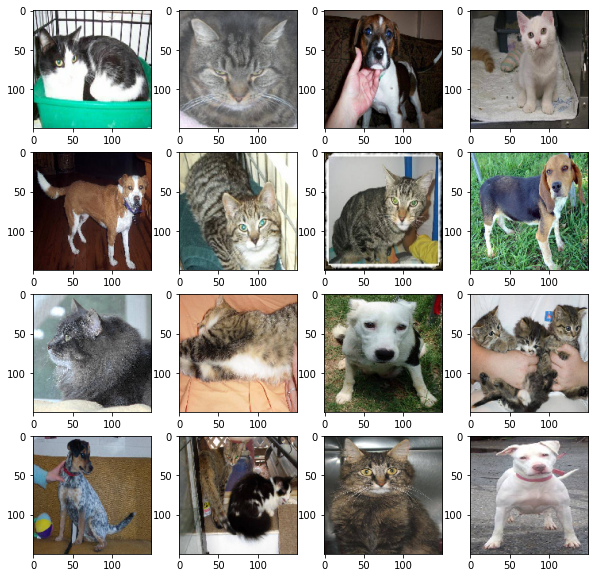

[[0.00465483]
 [0.07835238]
 [0.21272813]
 [0.15446165]
 [0.68342495]
 [0.11476037]
 [0.07248311]
 [0.9952459 ]
 [0.02928481]
 [0.01332836]
 [0.9987456 ]
 [0.0577544 ]
 [0.16689788]
 [0.23812315]
 [0.12209561]
 [0.83623475]]


In [ ]:
# 9.1 Make predictions
results = model.predict(images[0])

# 9.2 Plot the images and check with
#     results
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.figure(figsize= (10,10))
for i in range(results.shape[0]):
    plt.subplot(4,4,i+1)
    _=imshow(images[0][i]) ;

plt.show() ;
# 9.3 Predicted labels
print(results)         # Probability values
                       # > 0.5 is Dog

## Model saving

In [ ]:
## 10. Model saving
# 10.1 Install h5py using Anaconda
# 10.2 Save CNN model weights to a file
#     The h5py package is a Pythonic interface to HDF5 binary data format.
#     It lets you store huge amounts of numerical data, and easily manipulate
#     that data from NumPy. For example, you can slice into multi-terabyte
#     datasets stored on disk, as if they were real NumPy arrays.
#     Thousands of datasets can be stored in a single file, categorized and
#     tagged however you want.

# 10.3 Delete earlier model folder if it exists
# os.system('rm -rf  /root/ashok/model')
! rm -rf  /root/ashok/model

# 10.4 Create a fresh folder:
# os.mkdir("/home/ashok/useless")
! mkdir -p /root/ashok/model

# 10.5 Check for 'model' folder
! ls -la /root/ashok

total 20
drwxr-xr-x 4 root root 4096 Dec  2 10:26 .
drwx------ 1 root root 4096 Dec  2 09:10 ..
drwxrwxr-x 5 1000 1000 4096 Feb  7  2018 cats_dogs
drwxr-xr-x 2 root root 4096 Dec  2 10:26 model


In [ ]:
# 11.0 Save model weights
model.save_weights("/root/ashok/model/model_cats_dogs.h5")

# 11.1 Check the model-file and its size
! ls  -la /root/ashok/model

total 4776
drwxr-xr-x 2 root root    4096 Dec  2 10:26 .
drwxr-xr-x 4 root root    4096 Dec  2 10:26 ..
-rw-r--r-- 1 root root 4879936 Dec  2 10:26 model_cats_dogs.h5


In [ ]:
# 11.2 Copy saved file to your Google drive
! cp -r /root/ashok/model   /gdrive/MyDrive/Colab_data_files/cats_dogs

# 11.2.1 Check for file transfer to google drive
! ls /gdrive/MyDrive/Colab_data_files/cats_dogs/model

model_cats_dogs.h5


In [ ]:
# 11.3 Save your CNN model structure to
#      a file in 'json' format: cnn_model.json
cnn_model = model.to_json()
cnn_model

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 150, 150, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}}, {"class_name": "Conv2D", "config": {"name": "Ist_conv_layer", "trainable": true, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Activation", "config": {"name": "activation", "trainable": true, "dtype": "float32", "activation": "relu"}}, {"class_name": "MaxPooling2D", "config": {"name": "max_pooling2d", "trainabl

In [ ]:
# 11.4 Now save this json formatted data to a file on hard-disk
#     File name: cnn_model.json. File path: check with setwd()
# 11.4.1. Open/create file in write mode

#json_file = open("/home/ashok/useless/cnn_model.json", "w")
#json_file = open("c:\\users\\ashok\\useless\\cnn_model.json", "w")
json_file = open("/root/ashok/model/cnn_model.json", "w")

# 11.4.2 Write to file
json_file.write(cnn_model)
# 11.4.3 Close file
json_file.close()

# 11.5 Check for saved file
! ls -la /root/ashok/model

total 4784
drwxr-xr-x 2 root root    4096 Dec  2 10:28 .
drwxr-xr-x 4 root root    4096 Dec  2 10:26 ..
-rw-r--r-- 1 root root    4229 Dec  2 10:28 cnn_model.json
-rw-r--r-- 1 root root 4879936 Dec  2 10:26 model_cats_dogs.h5


## Loading model

In [ ]:
#%%                          F. Load model and model weights


## 12. Later

# 12.1 Open saved model file in read only mode
#     Just
# os.chdir("C:\\Users\\ashokharnal")

#json_file = open('/home/ashok/useless/cnn_model.json', 'r')
#json_file = open("c:\\users\\ashok\\useless\\cnn_model.json", "r")
json_file = open('/root/ashok/model/cnn_model.json', 'r')

loaded_model_json = json_file.read()
loaded_model_json            # Model structure in file: loded_model_json
json_file.close()

# 12.2 Create CNN model from the file: loaded_model_json
cnn_model = model_from_json(loaded_model_json)


# 12.3 load saved weights into new model
cnn_model.load_weights("/root/ashok/model/model_cats_dogs.h5")
#cnn_model.load_weights("c:\\users\\ashok\\useless\\first_try.h5")


# 12.4 Compile the model. Same way as was done earlier
cnn_model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])


#%%                         G. Make predictions on test data

# 13 Where is the directory which contains ANOTHER directory
#   containing your test images
#test_data_dir = validation_data_dir = 'E:/cats_and_dogs/test'


# 13.1 Augmentation configuration for test dataset.
#     Only rescaling as we did for validation data
test_datagen = ImageDataGenerator(rescale=1. / 255)


# 13.2 Create test data generator
test_generator = test_datagen.flow_from_directory(
        test_data_dir,                         # Which folder has test data
        target_size=(img_width, img_height),   # Resize images
        batch_size = test_batch_size,            # batch size to augment at a time
        class_mode=None)                       # Data has binary classes



# 14. Make predictions from loaded model. Takes few seconds.
start = time.time()
predictions = cnn_model.predict_generator(
        test_generator,
        steps= int(test_generator_samples/float(test_batch_size)), # all samples once
        verbose =1
        )
end  = time.time()
(end-start)/60

# 14.1 OR predictions directly from created model
start = time.time()
predictions1 = model.predict_generator(
        test_generator,
        steps=int(test_generator_samples/float(test_batch_size)), # all samples once
        verbose =1
        )

end  = time.time()
(end-start)/60


# 14.2 See arrays of predictions
#predictions
predictions[0:10]


## Submissions on Kaggle

In [ ]:
####--
#### Code to be corrected
####--
#%%                         H. Make submissions on Kaggle


# 15. Unfortunately Kaggle is not allowing submissions.
#     I have manually compiled a file looking at 300 images out of 12500
#     images in the test folder.
actual=pd.read_csv("E:/cats_and_dogs/actual_result300.csv", header = 0)
actual.head()

# 15.1 Add predictions column to this data frame
actual['new'] = predictions[0:300]

# 15. Evaluate accuracy
fpr, tpr, _ = metrics.roc_curve(actual['label'], actual['new'])

# 15.1 AUC
metrics.roc_auc_score(actual['label'], actual['new'])

# 15.2 ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange')
plt.show()

############ END ##############################################